# 1. Introduction

## 1.1. Glaucoma Detection with a Deep Learning Model Using Fundus Images

Glaucoma is a group of eye conditions that damage the optic nerve, which is crucial for maintaining good vision. This damage is often a result of abnormally high pressure in the eye. It is one of the leading causes of blindness in individuals over the age of 60.

---
In this project, we aim to leverage the power of Deep Learning to detect Glaucoma using fundus images. Fundus images are photographs of the interior surface of the eye and include structures such as the retina, optic disc, macula, and posterior pole (back of the eye). These images provide a wealth of information and are commonly used in diagnosing various eye diseases, including Glaucoma.

# 2. Libraries

In [1]:
! pip install monai

  Obtaining dependency information for monai from https://files.pythonhosted.org/packages/cb/96/f8ede335fa3501c57ec67163ef4d113427effc5ccfc8907c0bb58abe5e2d/monai-1.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for torch<2.7.0,>=2.4.1 from https://files.pythonhosted.org/packages/37/81/aa9ab58ec10264c1abe62c8b73f5086c3c558885d6beecebf699f0dbeaeb/torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/b5/00/d631e67a838026495268c2f6884f3711a15a9a2a96cd244fdaea53b823fb/typing_extensions-4.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.4.127 from https://files.pythonhosted.org/packages/2c/14/91ae57cd4db3f9ef7aa99f4019cfa8d54cb4caa7e00975df6467e9725a9f/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for nvidia-cuda-runtime-cu12==12.4.127 from https://files

In [2]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2
from scipy import io
from typing import List, Tuple, Dict, Union, Callable, Iterable

## 2.1. Deterministic Code

The next cell is designed to make your **Python, PyTorch, and MONAI** code **deterministic**, which means it will produce the same output given the same input. This is achieved by setting a specific seed for the random number generators in Python's random module, numpy, PyTorch, and MONAI. The function `make_deterministic(seed)` takes an integer `seed` as input and sets this seed for all the mentioned libraries. This ensures that any random number generation they perform will be consistent across multiple runs, which is crucial for reproducibility in experiments.

* **Deterministic Code**: Deterministic code, given the same input, will always produce the same output. This is crucial for reproducibility in experiments.
* **make_deterministic Function**: The function `make_deterministic(seed)` sets a specific seed for the random number generators in Python's random module, numpy, PyTorch, and MONAI. This ensures that any random number generation they perform will be consistent across multiple runs.

---

The second part of the code introduces a decorator `deterministic(func)`. A decorator in Python is a function that wraps another function to extend its behavior without explicitly modifying it. In this case, the `deterministic` decorator wraps around your function (denoted as `func`). Before your function is executed, it calls `make_deterministic(seed=random_seed)` to set the seed. If a `random_seed` is provided in the function arguments, it will use that; otherwise, it defaults to 0. By using this decorator with your function, like `@deterministic`, you ensure that the code inside your function is deterministic. However, remember that this does not guarantee complete determinism due to factors outside of these libraries' control.

* **Decorator**: A decorator in Python is a function that wraps another function to extend its behavior without explicitly modifying it.
* **deterministic Function**: The `deterministic(func)` decorator wraps around your function (denoted as `func`). Before your function is executed, it calls `make_deterministic(seed=random_seed)` to set the seed.


In [3]:
import random
import numpy as np
import torch
from monai.utils import set_determinism

def make_deterministic(seed):
    """
    Make the code deterministic using the specified seed for Python, PyTorch, and MONAI.
    
    Args:
        seed (int): The seed to use for random number generation.
    """
    # The seed for Python's random module
    random.seed(seed)
    
    # The seed for numpy
    np.random.seed(seed)
    
    # The seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # The seed for MONAI
    set_determinism(seed=seed)
    
def deterministic(func):
    """
    A decorator that makes a function deterministic.
    """
    def wrapper(*args, **kwargs):
        if 'random_seed' in kwargs:
            random_seed = kwargs['random_seed']
        else:
            random_seed = 0
        make_deterministic(seed=random_seed)
        return func(*args, **kwargs)
    return wrapper

## 2.2. Setting the Device: CPU or GPU?

A **CPU (Central Processing Unit)** and a **GPU (Graphics Processing Unit)** can be compared to a manager and a team of workers, respectively. 

- The **CPU**, like a manager, is great at handling a variety of tasks. It can quickly switch between tasks and handle complex operations. However, it has a limited number of cores (workers), so when it comes to very large tasks, such as processing high-resolution images or training complex deep learning models, it might take a long time to finish.

- On the other hand, a **GPU**, like a team of workers, excels at doing the same operation over and over again quickly. It has a lot more cores than a CPU. So, when a big project comes in, like processing a high-resolution image or running a complex machine learning model, the GPU can split the task among its many cores and finish the job much faster than a CPU.

In the context of image deep learning, setting the device to `cuda` means that you are choosing to use the GPU for computations, if one is available. Deep learning involves a lot of matrix operations (like multiplication and addition), which are highly parallelizable, and a GPU with its hundreds of cores can do these operations much faster than a CPU. This is especially true for image data, which usually involves high-dimensional matrices. Therefore, using `cuda` can significantly speed up the training and inference times of our deep learning models.

In [4]:
# Selecting the processor device. Making sure our accelerator is set to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

Device is: cuda


# 3. Dataset

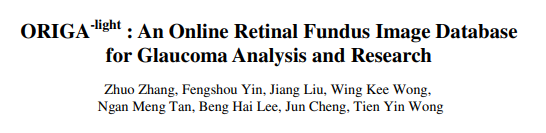
> Zhang, Zhuo & Yin, Feng & Liu, Jiang & Wong, Wing & Tan, Ngan & Lee, Beng-Hai & Cheng, Jun & Wong, T-Y. (2010). ORIGA(-light): An Online Retinal Fundus Image Database for Glaucoma Analysis and Research. Conference proceedings : ... Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. Conference. 2010. 3065-8. 10.1109/IEMBS.2010.5626137.
>[Kaggle Link](https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets)

In [5]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv") # dataframe to store the names of raw images data and gaucoma status
meta.head()
#In eye prescriptions, OD stands for oculus dexter, which is Latin for right eye
#OS stands for oculus sinister, which is Latin for left eye

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB


In [7]:
# Distribution of diagnosis in  dataset: 0: Normal, 1: Glaucoma
meta["Glaucoma"].value_counts()

Glaucoma
0    482
1    168
Name: count, dtype: int64

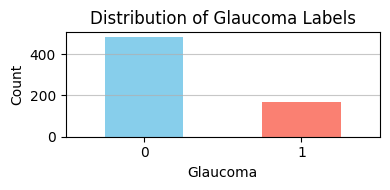

There is imbalance in data!


In [8]:
plt.figure(figsize=(4,2), dpi=100)  # 4 inches * 100 DPI = 400 pixels

meta['Glaucoma'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribution of Glaucoma Labels')
plt.xlabel('Glaucoma')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()
print("There is imbalance in data!")

In [9]:
img_root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
mask_root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Semi-automatic-annotations"

# Adding image and mask roots to the dataframe
meta["Image Path"] = meta["Filename"].apply(lambda fn: os.path.join(img_root, fn))
meta["Mask Path"] = meta["Filename"].apply(lambda fn: os.path.join(mask_root, f"{fn.split('.')[0]}.mat"))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Image Path,Mask Path
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...


### 3.1. Exploring Image Data

**Run the cell below to look at the mask contents**

In [10]:
mat_contents = io.loadmat(meta["Mask Path"][2])
mat_contents
mat_contents['mask'][1014:1034,1526:1546]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

**What are contours?**
Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

**Parameter Explanation :**

**mask:**
provided in the .mat files

**cv2.RETR_EXTERNAL:**

Retrieval mode: this retrieves only the external contours (outer boundaries).Other options include RETR_TREE, RETR_LIST, etc., which retrieve hierarchical/internal contours too.

**cv2.CHAIN_APPROX_SIMPLE:**

*If you pass cv.CHAIN_APPROX_NONE, all the boundary points are stored. But actually do we need all the points? For eg, you found the contour of a straight line. Do you need all the points on the line to represent that line? No, we need just two end points of that line. This is what cv.CHAIN_APPROX_SIMPLE does. It removes all redundant points and compresses the contour, thereby saving memory*

![Simple VS None](https://docs.opencv.org/3.4/none.jpg)

**Resize**

<img src="https://opencv.org/wp-content/uploads/2025/03/Resize-an-Image-1024x576.png" width="400">

In [11]:
def remove_black_padding(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find all contours
    cnt = max(contours, key=cv2.contourArea) # select the contour with the maximum area
    x,y,w,h = cv2.boundingRect(cnt) # find the corner points of the maximum area contour
    
    p = 30 # adding 30 cell padding
    crop = img[y-p:y+h+p, x-p:x+w+p] # crop the area of the maximum contour area from the original image not the mask image
    crop = cv2.resize(crop, (400, 300)) # what if it is smaller ?
    return crop

In [12]:
def get_subject_images(row):
    original_image = cv2.imread(row["Image Path"])#read the image

    # Loading mask from .mat file and extract numpy array of the mask, then make it one class
    mat = io.loadmat(row["Mask Path"]) # see the contents of mask structure ['__header__', '__version__', '__globals__', 'mask']
    binary_mask = (mat['mask'] > 0).astype(np.uint8) # 1 is white cells, 0 is black cells, we are highlighting black cells, set encoding to UNITEXT8
    mask = cv2.cvtColor(binary_mask*255, cv2.COLOR_GRAY2RGB)
    # binary_mask * 255: converts values from {0, 1} → {0, 255} to match 8-bit grayscale image format |
    #cv2.cvtColor(..., cv2.COLOR_GRAY2RGB): converts the 1-channel grayscale mask into a 3-channel RGB image

    # Apply mask to the original image
    if mask.size != original_image.size:
        shape = original_image.shape
        mask = cv2.resize(mask, (shape[1], shape[0]))
        
    masked = original_image * (mask > 0) # multiplication to overlap the  mask on it

    # Remove Black Padding
    removed_padding = remove_black_padding(original_image, binary_mask)# function defined above
    
    all_images = { # passing all images as a dictionary for display purpose ; training will be done of the "Removed Padding" image ,after data augmentation
        "Original Image": original_image,
        "Mask": mask,
        "Masked Image": masked,
        "Removed Padding": removed_padding # dimensions 400X300
    }
    
    return all_images

**Important note**



**we need to flip the channels , why tho ?**

Original order: [B, G, R] : OpenCV Default

Reversed: [R, G, B] : Matplotlib default


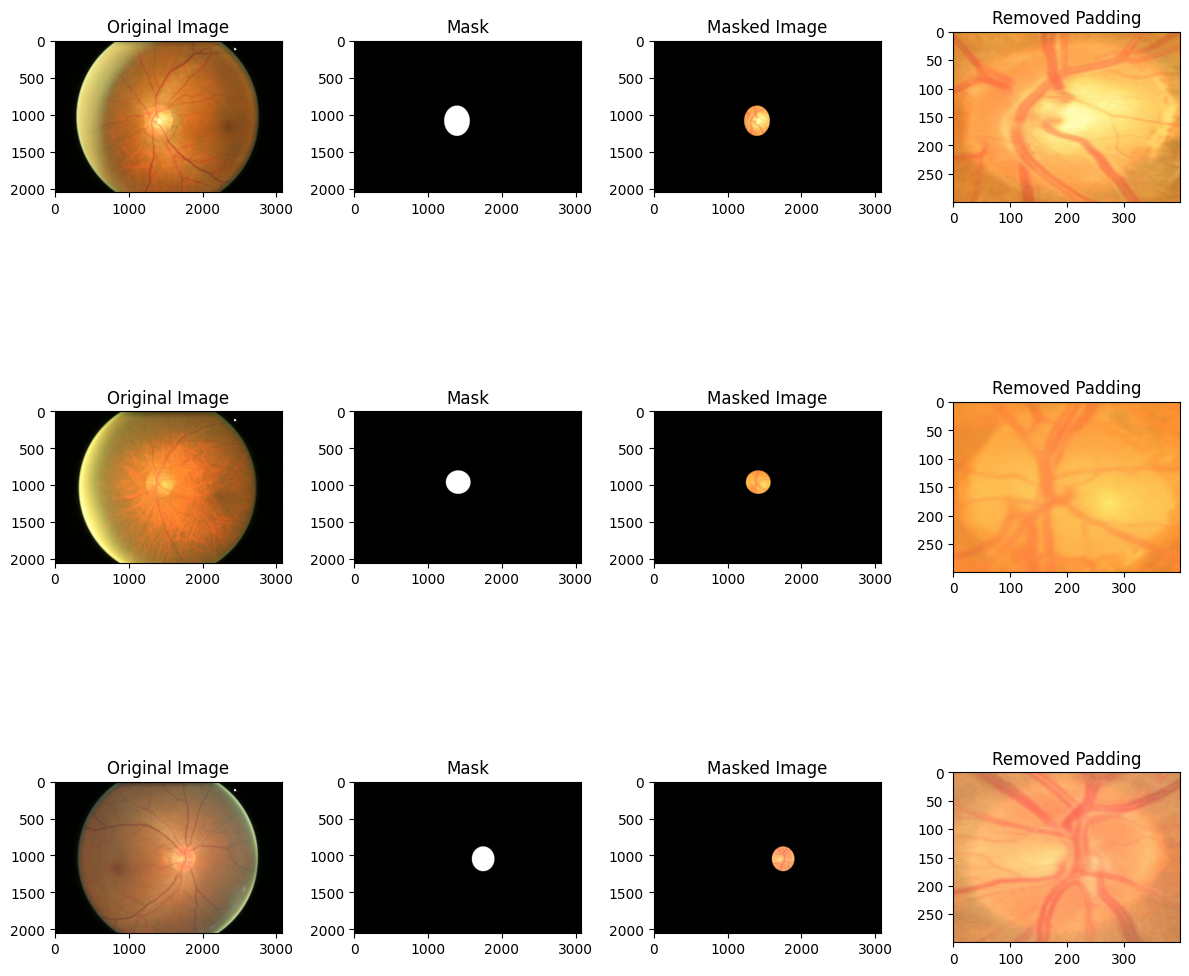

In [13]:

def visualize_images(num_subjects=3): # to show sample of the masking work that was done
    num_cols = 4
    fig, axs = plt.subplots(num_subjects, num_cols, figsize=(num_cols*3, num_cols*num_subjects))
    
    for i, row in meta.sample(n=num_subjects).reset_index().iterrows(): # sampling num_subject no. of rows from the meta dataframe
        all_images = get_subject_images(row) # defined in the above code cell
        for j, (title, image) in enumerate(all_images.items()): # .items() method in Python is a built-in dictionary method that shows key-value pairs of the dictionary
            axs[i, j].imshow(image[..., ::-1]) #reversing the last dimension (color channels) of the image.
            axs[i, j].set_title(title)

    plt.tight_layout()
    plt.show()
    
visualize_images(num_subjects=3)

### 3.2. Save Masked and Cropped Images

In [14]:
from tqdm.notebook import tqdm # for displaying a live progress bar

save_root = "/kaggle/working/masked-images"
os.makedirs(save_root, exist_ok=True) 

for i, row in tqdm(meta.iterrows(), total=len(meta)):
    all_images = get_subject_images(row)
    
    new_root = os.path.join(save_root, f"{row['Filename']}")
    cv2.imwrite(new_root, all_images["Removed Padding"]) # this file is saved to disk : syntax cv2.imwrite(filename, image)
    meta.at[i, "Cropped Path"] = new_root

  0%|          | 0/650 [00:00<?, ?it/s]

### Building datasets and data loaders

**MONAI**
MONAI (Medical Open Network for AI) is built on top of PyTorch and optimized for medical imaging tasks, like CT, MRI, etc.Its transforms are designed to **work on dictionaries of data**, not just single images (hence the D suffix).
Supports 3D 4D images as well
[Check it out!](https://monai.io/)

In [15]:
from monai.transforms import (LoadImageD, EnsureChannelFirstD, ResizeD, Compose,
                              NormalizeIntensityD, RandRotateD, RandZoomD,
                              LambdaD, ToTensorD, RepeatChannelD,
                              Rotate90d, SelectItemsd)
from monai.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [16]:
class GlaucomaDataset(Dataset):
    """
    A PyTorch Dataset class for the Glaucoma dataset.
    """

    def __init__(self, df, transform):
        """
        Initialize the dataset.

        Args:
            df (pandas.DataFrame): The dataframe containing the data.
            transform (callable): The transformations to apply to the data.
        """
        self.df = df
        self.transform = transform
        self.data = self.get_data()
    
    def get_data(self):
        """
        Extract the data from the dataframe.

        Returns:
            list: A list of tuples where each tuple contains the path to an image and its corresponding label.
        """
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"] # Training Label
            path = row["Cropped Path"] # Masked & Cropped Image
            data.append((path, label))
        return data
    
    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset and apply monai tranformations to it.

        Args:
            idx (int): The index of the sample to get.

        Returns:
            dict: A dictionary containing the image and its corresponding label.
        """
        image_path, label = self.data[idx]
        item_dict = {"image": image_path, "label": label}
        return self.transform(item_dict)

## 3.3 Glaucoma Dataset using `monai.transforms`
#### The transforms are applied to the fundus images for both training and testing datasets. 

The `aug_transforms` are applied to the training data for data augmentation, which helps the model generalize better. The `no_aug_transforms` (without random zooming) are applied to the testing data to evaluate the model's performance on new, unseen data.

---
>**NOTE:** Data augmentation is used on the training set to increase its diversity and help the model generalize better. However, the test set should represent real-world data that the model will encounter in production. Applying augmentation to the test set would mean testing the model on artificially created data, not on real-world data. This could give a misleading measure of the model's performance. Therefore, we typically only apply data augmentation to the training set, not the test set.
---


**RandRotateD**
> | Argument              | Meaning                                                                                                                                      |
| --------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| **`keys="image"`**    | The key in the input dictionary to which the rotation is applied (e.g., `"image"` or `"label"`).                                             |
| **`mode="bilinear"`** | Interpolation mode to use for rotation. Options: `"nearest"`, `"bilinear"`, etc.                                                             |
| **`range_x=0.26`**    | Rotation angle range along the **x-axis**, in **radians**. Here, `0.26 rad ≈ 15 degrees`. A random angle in `[-0.26, +0.26]` will be picked. |
| **`prob=0.5`**        | Probability of applying the rotation (50% chance).
>

**NORMALISE**

<img src="https://raw.githubusercontent.com/Project-MONAI/DocImages/main/transforms/NormalizeIntensityd.png" width="200">

**Why Normalise ?**

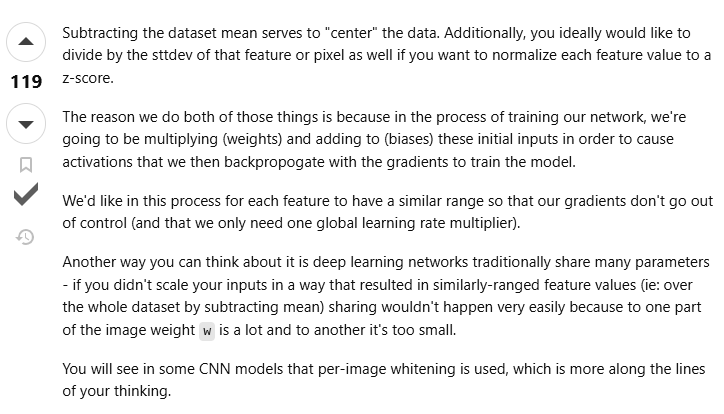
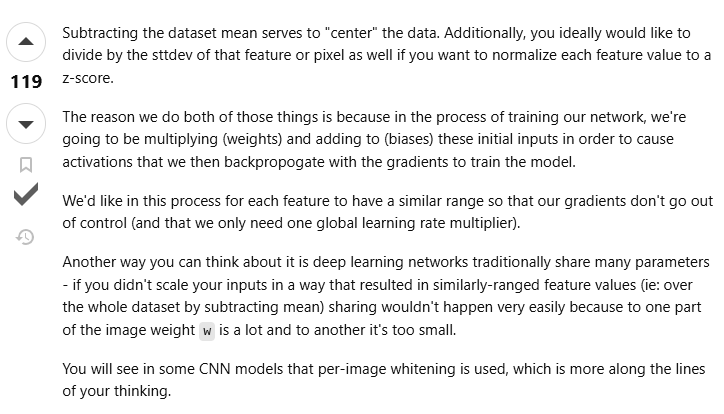

# Transforms for pre-processing

In [17]:
image_size = 224

# Building MONAI transforms
aug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          ResizeD(keys="image", spatial_size=(image_size, image_size)), #we transform to 224X224 ? why not before
          NormalizeIntensityD(keys="image"),
          RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
          RandZoomD(keys="image", mode="bilinear"),
          ToTensorD(keys=["image", "label"]),
          SelectItemsd(keys=["image", "label"])
        ])

no_aug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          ToTensorD(keys=["image", "label"]),
          SelectItemsd(keys=["image", "label"])
          ])

## 3.4. Concepts

In PyTorch, a `DataLoader` is used to load the data in a convenient format that makes it easy to feed into a model for training or testing. Here's what each parameter does:

- `train_data` and `test_data`: These are instances of a Dataset class which is defined. The `__len__` method, which returns the number of items in the dataset, and the `__getitem__` method, which returns the item (such as an image and its label) at a given index.

- `batch_size=bs`: This determines the number of samples per batch. This is often set to a power of 2, such as 4, 8, 16, etc., to take full advantage of hardware. The batch size can affect the model's performance and the speed of training.

- `shuffle=True` or `shuffle=False`: This determines whether to shuffle the data at every epoch for the training set (`shuffle=True`) or not for the test set (`shuffle=False`). Shuffling the training data is good practice as it removes correlation between batches and helps the model generalize better.

- `drop_last=True`: This is used when the dataset size is not a multiple of the batch size. This is typically set to `True` for training data to ensure that all batches have the same size, but it's not necessary for the test data.


**Note**
The data is imabalanced i.e. out of 650 images 482 dont have Glaucoma, 168 have Glaucoma

**Goal :** To create a balanced dataset by combining two groups of data (meta_nl and meta_gl) so that both have the same number of samples.

**Why ? :** To make sure your model doesn't become biased toward the larger class. Balanced datasets lead to fairer and better model training.


In [18]:
meta_nl = meta.loc[meta["Glaucoma"] == 0]
meta_gl = meta.loc[meta["Glaucoma"] == 1]
#To make sure model doesn't become biased toward the larger class. 
#Balanced datasets lead to fairer and better model training.
new_meta = pd.concat([meta_nl.sample(n=len(meta_gl)), meta_gl]).copy()

train_df, test_df = train_test_split(new_meta, test_size=0.25)

#GlaucomaDatasetClass defined  above
train_data = GlaucomaDataset(train_df, aug_transforms)
test_data = GlaucomaDataset(test_df, no_aug_transforms)# We do not augment the testing data ever, get a true estimate of test error

bs = 8

train_dl = DataLoader(train_data, batch_size=bs, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=bs, shuffle=False)


sample_batch = next(iter((train_dl)))
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['label'] shape: {sample_batch['label'].shape}")
print(f"batch['label'] dtype: {sample_batch['label'].dtype}")

batch['image'] shape: torch.Size([8, 3, 224, 224])
batch['image'] dtype: torch.float32
batch['label'] shape: torch.Size([8])
batch['label'] dtype: torch.int64


In [64]:
print(test_data.__getitem__(9)) #the image looks like this

{'image': metatensor([[[ 2.0948e-01,  1.8785e-01,  1.9386e-01,  ...,  1.1153e-02,
           4.0000e-02,  7.9666e-02],
         [ 1.9145e-01,  1.7222e-01,  1.8103e-01,  ..., -6.6248e-05,
           2.3172e-02,  5.9232e-02],
         [ 2.0588e-01,  1.8905e-01,  1.7142e-01,  ..., -6.6248e-05,
           1.3557e-02,  4.2404e-02],
         ...,
         [-1.5953e-01, -1.4992e-01, -1.4270e-01,  ...,  8.0067e-02,
           8.3272e-02,  8.5676e-02],
         [-2.0280e-01, -2.0761e-01, -1.8918e-01,  ...,  8.0067e-02,
           8.0868e-02,  8.0868e-02],
         [-1.9078e-01, -2.1242e-01, -2.0040e-01,  ...,  7.3656e-02,
           8.3272e-02,  9.4090e-02]],

        [[-9.0116e-01, -9.2280e-01, -9.1679e-01,  ..., -1.1331e+00,
          -1.1139e+00, -1.0887e+00],
         [-8.9996e-01, -9.1919e-01, -9.1358e-01,  ..., -1.1460e+00,
          -1.1307e+00, -1.1091e+00],
         [-8.7592e-01, -8.9275e-01, -9.0236e-01,  ..., -1.1524e+00,
          -1.1452e+00, -1.1259e+00],
         ...,
         [-

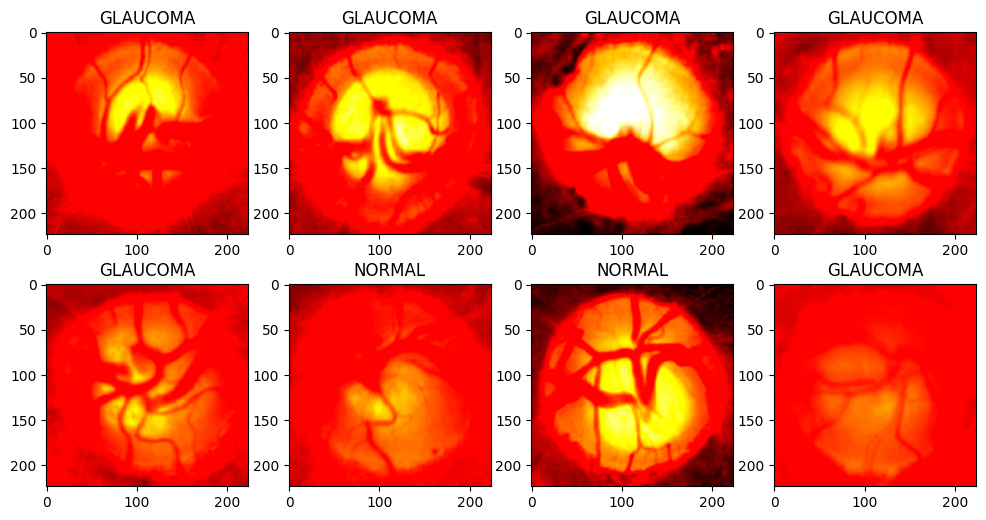

In [52]:
# Plotting sample images from the dataloaders.

#@deterministic
def plot_sample_dataloader_images(dataloader):
    """
    Plot 9 sample images from either the training or test dataloaders.
    """
    label_tensor_dict = {1:'GLAUCOMA', 0:'NORMAL'}
    dataiter = iter(dataloader)
    image_tensor_list = list()
    label_list = list()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    data = next(dataiter)
    image_batch, label_batch = data['image'], data['label']
    for i in range(8):
        axes[i//4, i%4].imshow(image_batch[i].permute(1, 2, 0))
        axes[i//4, i%4].set_title(label_tensor_dict[int(label_batch[i])])
    plt.show()

plot_sample_dataloader_images(test_dl)

# 4. Deep Learning Model

In [20]:
import torchvision.models as models
import torch.nn as nn


# 5. Training

## Concepts

### Criterion (Loss Function)
The `criterion` in PyTorch is another name for the loss function. It's a method of evaluating how well specific algorithm models the given data. If predictions deviate too much from actual results, loss function would cough up a very large number. we use cross entropy loss for classification.

### Learning Rate
The `learning rate` is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. It is usually represented as:
$$\theta = \theta - \eta . \nabla_\theta J( \theta)$$
where $\theta$ represents the parameters, $\eta$ is the learning rate and $\nabla_\theta J( \theta)$ is the gradient of the loss function $J( \theta)$ with respect to the parameters.

### Optimizer
The `optimizer` in PyTorch is an implementation of a specific optimization algorithm which is used to update the parameters of the model (weights and biases). We use SGD.  `Gradient Descent` is an optimization algorithm used to minimize some function (here, the loss) by iteratively moving in the direction of steepest descent as defined by the negative of the gradient.

#### Model Eval and Model Train
In PyTorch, `model.train()` and `model.eval()` are used to switch between training and evaluation modes. 

When `model.train()` is called, the model is set to training mode. This activates the gradients, enabling backpropagation and parameter updates during optimization. It also activates regularization techniques like Dropout and Batch Normalization, which behave differently during training and evaluation. Dropout randomly zeroes some of the layer's outputs to prevent overfitting, and Batch Normalization normalizes layer inputs to maintain stable learning. 

When `model.eval()` is called, the model is set to evaluation mode, deactivating gradients and the aforementioned regularization techniques. This ensures the model produces more deterministic results during evaluation, which is essential for model assessment.


### Loss.backward and Gradient Descent
`loss.backward()` computes the gradient of the loss with respect to the parameters using backpropagation.

`optimizer.step` performs a parameter update based on the current gradient (stored in `.grad` attribute of a parameter).


In [21]:
import shutil

In [22]:
def train_classifier(model: torch.nn.Module,
                     model_name: str,
                     train_loader: Iterable,
                     valid_loader: Iterable,
                     criterion: Callable,
                     optimizer: torch.optim,
                     num_epochs: int,
                     plot_curves: bool):
    """
    Train a classifier model using PyTorch and the given parameters.
    """
#Transfer to GPU
    model.to(device)
    
#zero out the gradients at the start of a new minibatch. 
#By default, gradients in PyTorch are accumulated, so we need to explicitly zero them out.
    
    with torch.no_grad(): 
        torch.cuda.empty_cache()

    # Lists to store epoch metrics
    epoch_train_loss_list = []
    epoch_train_accuracy_list = []
    epoch_valid_loss_list = []
    epoch_valid_accuracy_list = []

    # Building a saving directory for models
    model_save_dir = os.path.join('Best_Models', model_name)
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir) # remove old data
        
    os.makedirs(model_save_dir, exist_ok=True)    

    for epoch in range(1, num_epochs + 1):
        print("-" * 20, f'\nStarting epoch: {epoch}/{num_epochs}')

        # Training phase
        model.train()
        steps_train_loss = 0.0
        steps_correct_predictions = 0

        for batch in train_loader:
            inputs, labels = batch['image'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            steps_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        epoch_train_loss = steps_train_loss / len(train_loader)
        epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
        epoch_train_loss_list.append(epoch_train_loss)
        epoch_train_accuracy_list.append(epoch_train_accuracy)

        # Validation phase
        model.eval()
        steps_valid_loss = 0.0
        steps_correct_predictions = 0

        for batch in valid_loader:
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            steps_valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        epoch_valid_loss = steps_valid_loss / len(valid_loader)
        epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
        epoch_valid_loss_list.append(epoch_valid_loss)
        epoch_valid_accuracy_list.append(epoch_valid_accuracy)

        print(f'train loss: {epoch_train_loss:.2f} | train accuracy: {epoch_train_accuracy:.2f}')
        print(f'valid loss: {epoch_valid_loss:.2f} | valid accuracy: {epoch_valid_accuracy:.2f}')

    ## Saving the best model
        if epoch==1:
            best_valid_loss = epoch_valid_loss
            weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
        elif epoch_valid_loss < best_valid_loss:
            weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
            best_valid_loss = epoch_valid_loss

    # Printing the best model
    print(f'\nTraining was over. The best model was: {weight_name}')
   

    # Plotting loss and accuracy curves
    if plot_curves:
        epoch_train_loss_list.insert(0, 0)
        epoch_train_accuracy_list.insert(0, 0)
        epoch_valid_loss_list.insert(0, 0)
        epoch_valid_accuracy_list.insert(0, 0)

        fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
        axes[0].plot(epoch_train_loss_list, color='blue', label='training')
        axes[0].plot(epoch_valid_loss_list, color='orange', label='validation')
        axes[0].set_xlim(1, len(epoch_valid_loss_list) + 1)
        axes[0].set_title('Loss curves')
        axes[0].legend()

        axes[1].plot(epoch_train_accuracy_list, color='blue', label='training')
        axes[1].plot(epoch_valid_accuracy_list, color='orange', label='validation')
        axes[1].set_xlim(1, len(epoch_train_accuracy_list) + 1)
        axes[1].set_title('Accuracy curves')
        axes[1].legend()

    model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
    return model


# vgg19

<img src ="https://media.geeksforgeeks.org/wp-content/uploads/20240607123924/VGG--19-Architecture-.webp" width="600">

-------------------- 
Starting epoch: 1/40
train loss: 0.69 | train accuracy: 0.52
valid loss: 0.69 | valid accuracy: 0.49
-------------------- 
Starting epoch: 2/40
train loss: 0.69 | train accuracy: 0.51
valid loss: 0.69 | valid accuracy: 0.49
-------------------- 
Starting epoch: 3/40
train loss: 0.69 | train accuracy: 0.50
valid loss: 0.69 | valid accuracy: 0.49
-------------------- 
Starting epoch: 4/40
train loss: 0.69 | train accuracy: 0.49
valid loss: 0.69 | valid accuracy: 0.51
-------------------- 
Starting epoch: 5/40
train loss: 0.69 | train accuracy: 0.50
valid loss: 0.69 | valid accuracy: 0.55
-------------------- 
Starting epoch: 6/40
train loss: 0.70 | train accuracy: 0.46
valid loss: 0.69 | valid accuracy: 0.50
-------------------- 
Starting epoch: 7/40
train loss: 0.69 | train accuracy: 0.50
valid loss: 0.69 | valid accuracy: 0.49
-------------------- 
Starting epoch: 8/40
train loss: 0.69 | train accuracy: 0.53
valid loss: 0.69 | valid accuracy: 0.51
----------------

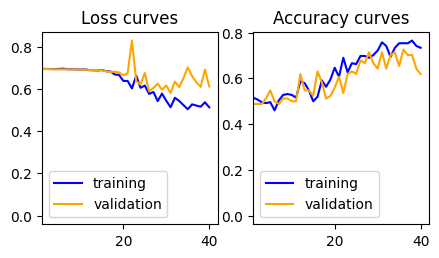

In [27]:
vgg19_model_1 = models.vgg19(pretrained= False)
vgg19_model_1.classifier._modules['6'] = nn.Linear(4096, 2) #modifying classifier layer at the end to 2 class from 1000
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(vgg19_model_1.parameters(), lr=learning_rate)
num_epochs = 40
vgg19_model_1 = train_classifier(model=vgg19_model_1,
                                 model_name='vgg19_model_1',
                                 train_loader=train_dl,
                                 valid_loader=test_dl,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

# resnet18

-------------------- 
Starting epoch: 1/40
train loss: 0.73 | train accuracy: 0.50
valid loss: 0.71 | valid accuracy: 0.51
-------------------- 
Starting epoch: 2/40
train loss: 0.69 | train accuracy: 0.56
valid loss: 0.71 | valid accuracy: 0.56
-------------------- 
Starting epoch: 3/40
train loss: 0.68 | train accuracy: 0.58
valid loss: 0.71 | valid accuracy: 0.58
-------------------- 
Starting epoch: 4/40
train loss: 0.68 | train accuracy: 0.56
valid loss: 0.71 | valid accuracy: 0.48
-------------------- 
Starting epoch: 5/40
train loss: 0.69 | train accuracy: 0.58
valid loss: 1.01 | valid accuracy: 0.48
-------------------- 
Starting epoch: 6/40
train loss: 0.63 | train accuracy: 0.62
valid loss: 0.66 | valid accuracy: 0.65
-------------------- 
Starting epoch: 7/40
train loss: 0.58 | train accuracy: 0.72
valid loss: 0.78 | valid accuracy: 0.61
-------------------- 
Starting epoch: 8/40
train loss: 0.64 | train accuracy: 0.62
valid loss: 0.74 | valid accuracy: 0.58
----------------

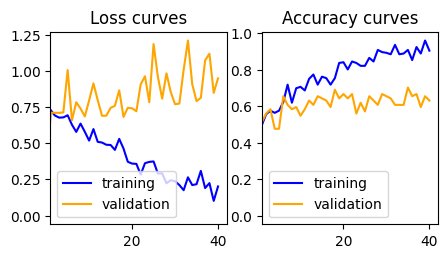

In [28]:
resnet18 = models.resnet18(pretrained=False)
num_in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_in_features, 2) # add a fc layer at the end
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(resnet18.parameters(), lr=learning_rate)
num_epochs = 40
resnet18 = train_classifier(model=resnet18,
                                 model_name='resnet',
                                 train_loader=train_dl,
                                 valid_loader=test_dl,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

# 6. Evaluation

## 6.1. Concepts

- `model.eval()` is used to set the model to evaluation mode. This is done before testing a model. On the other hand, `model.train()` is used to set the model to training mode before training it.

- The line `preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)` is used to get the model's predictions.

- 
 <br><img src="https://i.ibb.co/JCPxvzJ/img5.jpg" alt="img5" border="0" width="400" height="100"><br>
 [Sklearn Link to metrics](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns


def evaluate_model(model: Callable,
                   test_loader: Iterable = test_dl,
                   plot_cm: bool = True) -> float:
    """
    Evaluate a given model's performance on the test set.
    Parameters:
        model (Callable): the pytorch model to be evaluated.
        test_loader (Iterable): test dataloader to be used as the test data.
        plot_cm (bool): whether or not to plot a confusion matrix.
        accuracy (float): accuracy of the model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    labels_list = list()
    preds_list = list()
    with torch.no_grad():
        for batch in test_dl:
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            labels_list.append(labels)
            preds_list.append(preds)
        all_labels = torch.cat(labels_list).cpu() # concatenate to the the list as iteartes through data loader
        all_preds = torch.cat(preds_list).cpu() # concatenate to the the list as iteartes through data loader
        accuracy = (all_preds == all_labels).sum().item()/len(all_labels)
        y_true = all_labels.numpy()
        y_pred = all_preds.numpy()

    if plot_cm:
        cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
        ax = plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'Confusion Matrix -Test accuracy: {accuracy:.3f}')
        ax.xaxis.set_ticklabels(['Glaucoma', 'Normal'])
        ax.yaxis.set_ticklabels(['Glaucoma', 'Normal'])
        
        # Macro/micro-averaged precision, recall, F1-score
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        print(f" Precision : {precision:.4f}")
        print(f" Recall : {recall:.4f}")
        print(f" F1-score : {f1:.4f}")




    

 Precision : 0.7162
 Recall : 0.7153
 F1-score : 0.7141


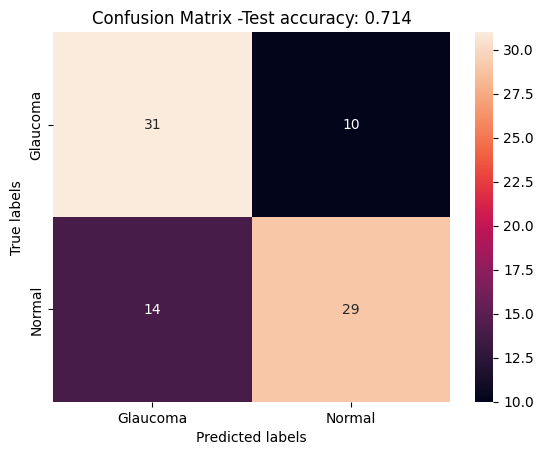

In [29]:
evaluate_model(vgg19_model_1)

 Precision : 0.6548
 Recall : 0.6548
 F1-score : 0.6547


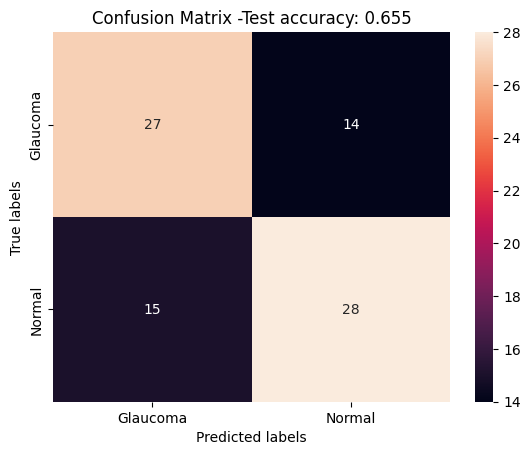

In [30]:
evaluate_model(resnet18)

## Fitting with Transfer Learning

In [47]:
resnet18_model_TL = models.resnet18(pretrained=True)
num_in_features = resnet18.fc.in_features
resnet18_model_TL.fc = nn.Linear(num_in_features, 2) # add a fc layer at the end
children_num_to_freeze = 7

for i, child in enumerate(resnet18_model_TL.children()):
        if i < children_num_to_freeze:
            status = 'Frozen'
            for param in child.parameters():
                param.requires_grad = False
        else:
            status = 'Unfrozen'
        for param in child.parameters():
            param.requires_grad = True
            
            print(f'*** child module number: {i} - {status}')
           
   

*** child module number: 0 - Frozen
*** child module number: 1 - Frozen
*** child module number: 1 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 4 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 - Frozen
*** child module number: 5 -

-------------------- 
Starting epoch: 1/40
train loss: 0.35 | train accuracy: 0.86
valid loss: 1.00 | valid accuracy: 0.57
-------------------- 
Starting epoch: 2/40
train loss: 0.29 | train accuracy: 0.88
valid loss: 0.90 | valid accuracy: 0.62
-------------------- 
Starting epoch: 3/40
train loss: 0.23 | train accuracy: 0.92
valid loss: 0.82 | valid accuracy: 0.54
-------------------- 
Starting epoch: 4/40
train loss: 0.16 | train accuracy: 0.94
valid loss: 0.91 | valid accuracy: 0.56
-------------------- 
Starting epoch: 5/40
train loss: 0.14 | train accuracy: 0.94
valid loss: 0.84 | valid accuracy: 0.67
-------------------- 
Starting epoch: 6/40
train loss: 0.13 | train accuracy: 0.94
valid loss: 0.89 | valid accuracy: 0.61
-------------------- 
Starting epoch: 7/40
train loss: 0.17 | train accuracy: 0.92
valid loss: 0.77 | valid accuracy: 0.68
-------------------- 
Starting epoch: 8/40
train loss: 0.14 | train accuracy: 0.94
valid loss: 1.28 | valid accuracy: 0.58
----------------

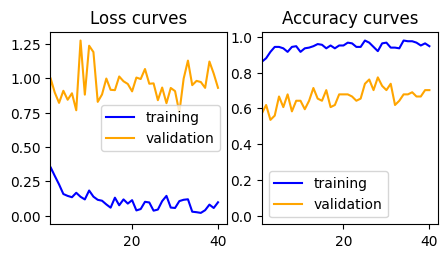

In [51]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(resnet18_model_TL.parameters(), lr=learning_rate,momentum=0.8,
                            weight_decay=0.001)
num_epochs = 40
resnet18_model_2 = train_classifier(model=resnet18_model_TL,
                                 model_name='resnet18_model_2',
                                 train_loader=train_dl,
                                 valid_loader=test_dl,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

 Precision : 0.6786
 Recall : 0.6787
 F1-score : 0.6785


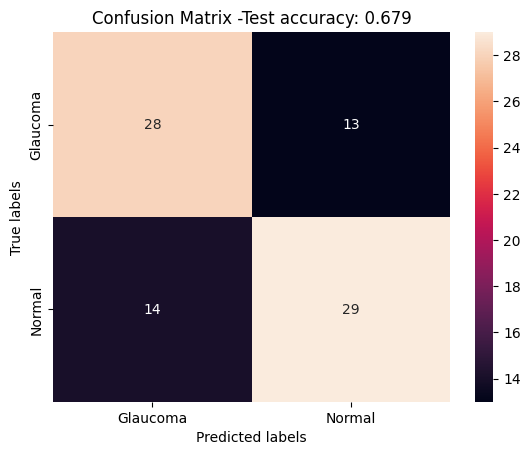

In [49]:
evaluate_model(resnet18_model_2)

In [43]:
print("Children of the model:")
for i, child in enumerate(resnet18_model_TL.named_children()):
    print(f"Child {i}: {child}")


Children of the model:
Child 0: ('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
Child 1: ('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
Child 2: ('relu', ReLU(inplace=True))
Child 3: ('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
Child 4: ('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# 7. Acknowledgements

I would like to express my gratitude to the authors of the referenced notebook for their valuable information and insights. Their work greatly contributed to the development of this notebook. You can find the original notebook here:
[Authors: Pouria Rouzrokh, MD, MPH, MHPE; Bardia Khosravi, MD, MPH, MHPE](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/9A.ipynb#scrollTo=83Up5jCrSPQD)

Thank you!

 Precision : 0.7500
 Recall : 0.7501
 F1-score : 0.7500


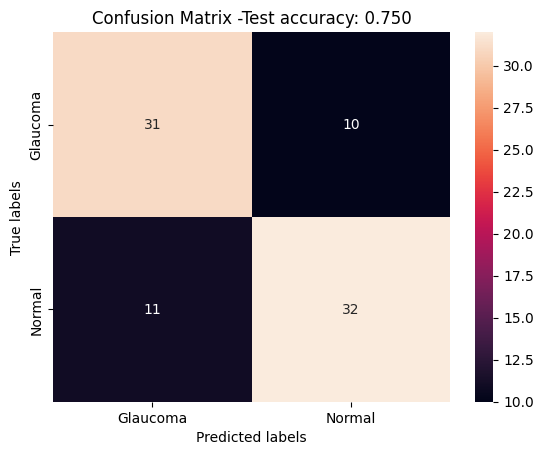

In [36]:

evaluate_model(resnet18_model_2)